# 1.3 Comparison and Analysis

### Loading the 3 Models

In [1]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import warnings
from torchvision import models

# Ignore warnings
warnings.filterwarnings("ignore")

# Define file paths for each model
baseline_model_path = '/content/drive/MyDrive/vgg11_baseline.pth'
unstructured_pruned_model_path = '/content/drive/MyDrive/pruned_vgg11_model.pth'
structured_pruned_model_path = '/content/drive/MyDrive/pruned_vgg11_model_structured.pth'

# Function to load and configure a VGG-11 model for CIFAR-100 (100 classes)
def load_model_for_cifar100(model_path):
    model = models.vgg11(pretrained=False)
    model.classifier[6] = torch.nn.Linear(4096, 100)  # Modify final layer for CIFAR-100 (100 classes)
    model.load_state_dict(torch.load(model_path))
    return model

# Load the models
baseline_model = load_model_for_cifar100(baseline_model_path)
unstructured_pruned_model = load_model_for_cifar100(unstructured_pruned_model_path)
structured_pruned_model = load_model_for_cifar100(structured_pruned_model_path)

# Verify that models have been loaded successfully
print("Baseline model loaded successfully." if baseline_model else "Failed to load baseline model.")
print("Unstructured pruned model loaded successfully." if unstructured_pruned_model else "Failed to load unstructured pruned model.")
print("Structured pruned model loaded successfully." if structured_pruned_model else "Failed to load structured pruned model.")


# Move models to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model = baseline_model.to(device)
unstructured_pruned_model = unstructured_pruned_model.to(device)
structured_pruned_model = structured_pruned_model.to(device)


Baseline model loaded successfully.
Unstructured pruned model loaded successfully.
Structured pruned model loaded successfully.


### Grad-CAM Implementation

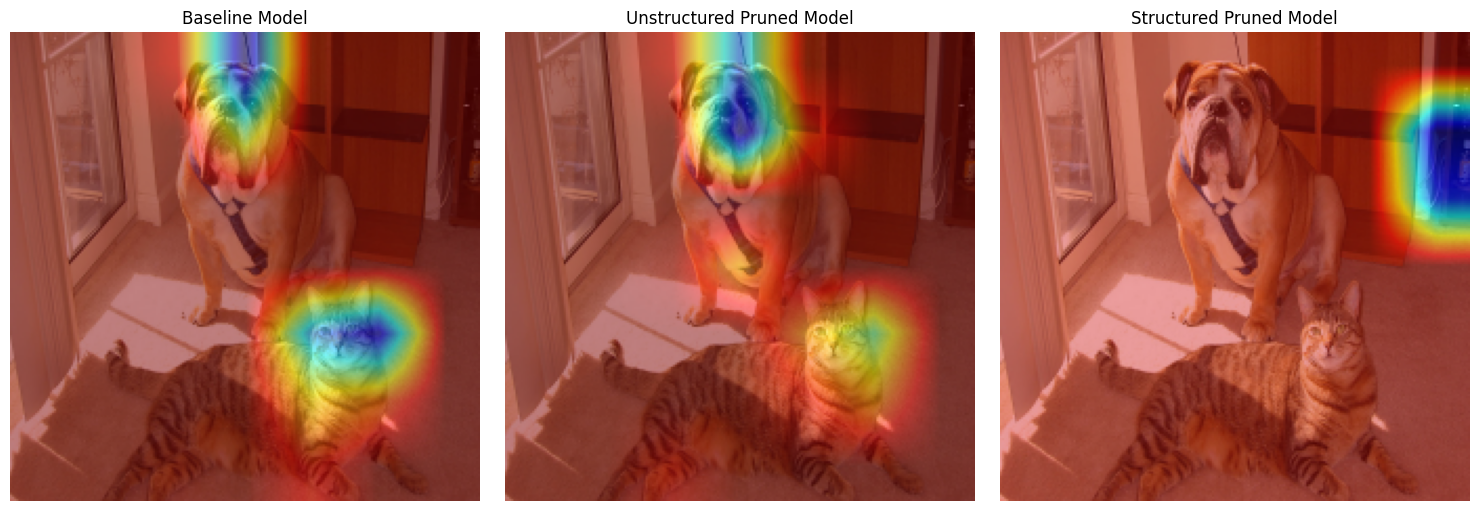

In [3]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Define transformations for input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

# Function to preprocess image for model input
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Load an example image for Grad-CAM (replace with an actual CIFAR-100 image path)
example_image_path = "/content/drive/MyDrive/grad-cam-dog-cat.png"
input_image = preprocess_image(example_image_path).to(device)

# Grad-CAM setup
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax().item()
        target = output[0, class_idx]
        target.backward()

        # Compute the Grad-CAM heatmap
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        grad_cam = (weights * self.activations).sum(dim=1).squeeze()
        grad_cam = F.relu(grad_cam).cpu().detach().numpy()
        grad_cam = cv2.resize(grad_cam, (224, 224))
        grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())  # Normalize
        return grad_cam

# Function to overlay heatmap on original image
def overlay_heatmap(image, heatmap):
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    image = np.array(image.resize((224, 224))) / 255
    cam_image = heatmap + image
    return np.uint8(255 * cam_image / cam_image.max())

# Generate Grad-CAM visualizations for baseline, unstructured pruned, and structured pruned models
models = {
    "Baseline Model": baseline_model,
    "Unstructured Pruned Model": unstructured_pruned_model,
    "Structured Pruned Model": structured_pruned_model
}

# Display Grad-CAM results for each model
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, (title, model) in enumerate(models.items()):
    target_layer = model.features[-1]  # Last conv layer
    grad_cam = GradCAM(model, target_layer)
    heatmap = grad_cam.generate_heatmap(input_image)
    cam_image = overlay_heatmap(Image.open(example_image_path), heatmap)

    axes[idx].imshow(cam_image)
    axes[idx].set_title(title)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


`Baseline Model:`

- The baseline model appears to focus on both the dog and the cat, highlighting essential regions around their faces. This indicates that the model considers both objects in the scene and pays attention to relevant features (e.g., eyes, nose) to identify each animal.

`Unstructured Pruned Model:`

- The unstructured pruned model shows a similar focus to the baseline model, with strong attention on the dog's head and the cat's face. Although there is a slight reduction in intensity, the regions of interest remain quite similar, suggesting that unstructured pruning has preserved the model’s interpretability and attention patterns.
- This is consistent with unstructured pruning, where individual weights are pruned without explicitly removing entire channels or features, allowing the model to retain most of its original focus.

`Structured Pruned Model:`

- The structured pruned model shows a more significant change. The focus on the dog's face remains, but the attention on the cat’s face has shifted significantly, with heatmap regions moving to the background on the right side of the image.
- This behavior is expected in structured pruning, where entire channels are removed, potentially leading to a loss of feature-specific information. This model might have lost some of its ability to fully recognize multiple objects in the scene, possibly due to the reduced capacity to capture fine details about each animal.

`Key Observations:`
1. Focus Retention: The baseline and unstructured pruned models have similar focus regions, indicating that unstructured pruning retains more of the original model's interpretability.
2. Focus Shift: The structured pruned model shows a shift in focus, which could imply that it is less effective at capturing all relevant objects in complex scenes.

`Conclusion:`
- Unstructured Pruning: This approach seems to maintain interpretability better, preserving key focus areas and enabling the model to still recognize both objects.
- Structured Pruning: While it may lead to more computational efficiency, it comes at the cost of reduced interpretability and potential loss of essential focus, especially in multi-object scenarios.

### Accuracy Comparison

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torchvision import datasets, transforms
from tqdm import tqdm

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for the CIFAR-100 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to modify model for CIFAR-100 and freeze all layers except the final layer
def prepare_model_for_finetuning(model):
    # Modify the final layer for 100 classes
    model.classifier[6] = nn.Linear(4096, 100).to(device)

    # Freeze all layers except the last classifier layer
    for param in model.features.parameters():
        param.requires_grad = False
    for param in model.classifier[:-1]:  # Freeze all but last layer in classifier
        param.requires_grad = False

    return model

# Fine-tune function
def finetune_model(model, train_loader, epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001, weight_decay=1e-4)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Fine-tuning Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Calculate accuracy
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating model"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Prepare and fine-tune each model
models = {
    "Baseline Model": baseline_model,
    "Unstructured Pruned Model": unstructured_pruned_model,
    "Structured Pruned Model": structured_pruned_model
}

results = []
for name, model in models.items():
    model = prepare_model_for_finetuning(model.to(device))  # Modify model for CIFAR-100 and freeze layers
    finetune_model(model, train_loader, epochs=3)
    accuracy = calculate_accuracy(model, test_loader)  # Calculate accuracy on the test set
    results.append({"Model": name, "Accuracy (%)": accuracy * 100})

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Display the results as a table
print(results_df)

# Display results as a styled table
styled_results = results_df.style.set_properties(**{
    'background-color': 'black',
    'color': 'white',
    'border-color': 'white'
}).set_table_styles([{
    'selector': 'thead th',
    'props': [('background-color', 'darkgreen'), ('color', 'white')]
}]).set_caption("Accuracy Comparison of Baseline, Unstructured Pruned, and Structured Pruned Models on CIFAR-100 Test Set")

styled_results


100%|██████████| 169M/169M [00:03<00:00, 42.3MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Fine-tuning Epoch 1/3: 100%|██████████| 782/782 [03:49<00:00,  3.41it/s]


Epoch [1/3], Loss: 1.9477


Fine-tuning Epoch 2/3: 100%|██████████| 782/782 [03:48<00:00,  3.42it/s]


Epoch [2/3], Loss: 1.6237


Fine-tuning Epoch 3/3: 100%|██████████| 782/782 [03:48<00:00,  3.43it/s]


Epoch [3/3], Loss: 1.5649


Fine-tuning Epoch 1/3: 100%|██████████| 782/782 [03:46<00:00,  3.45it/s]


Epoch [1/3], Loss: 2.9218


Fine-tuning Epoch 2/3: 100%|██████████| 782/782 [03:46<00:00,  3.46it/s]


Epoch [2/3], Loss: 2.6319


Fine-tuning Epoch 3/3: 100%|██████████| 782/782 [03:46<00:00,  3.45it/s]


Epoch [3/3], Loss: 2.5945


Fine-tuning Epoch 1/3: 100%|██████████| 782/782 [03:42<00:00,  3.52it/s]


Epoch [1/3], Loss: 3.7054


Fine-tuning Epoch 2/3: 100%|██████████| 782/782 [03:41<00:00,  3.53it/s]


Epoch [2/3], Loss: 3.4261


Fine-tuning Epoch 3/3: 100%|██████████| 782/782 [03:40<00:00,  3.54it/s]


Epoch [3/3], Loss: 3.3714


Evaluating model: 100%|██████████| 157/157 [00:43<00:00,  3.65it/s]

                       Model  Accuracy (%)
0             Baseline Model         61.00
1  Unstructured Pruned Model         42.92
2    Structured Pruned Model         26.38


,Model,Accuracy (%)
0,Baseline Model,61.000000
1,Unstructured Pruned Model,42.920000
2,Structured Pruned Model,26.380000


### Qualitative analysis of Structured vs. Unstructured Pruning

In [6]:
import pandas as pd

# Define data for the comparison table
data = {
    "Aspect": [
        "Pruning Granularity",
        "Hardware Compatibility",
        "Memory Access Patterns",
        "Parallelism",
        "Implementation Complexity",
        "Impact on Model Accuracy",
        "Storage Requirements"
    ],
    "Structured Pruning": [
        "Entire channels, filters, or blocks are removed.",
        "Efficient on general-purpose hardware (GPUs/TPUs) due to dense operations.",
        "Contiguous, optimized for general memory access.",
        "Maintains high parallelism due to dense structure.",
        "Easier to implement with standard libraries and retraining.",
        "Coarser granularity can cause higher accuracy loss without careful retraining.",
        "Compact, fits standard storage formats without extra encoding."
    ],
    "Unstructured Pruning": [
        "Individual weights are pruned within layers.",
        "May need specialized hardware for efficient sparse matrix operations.",
        "Irregular, leading to complex memory access and indexing.",
        "Reduced parallelism; sparse operations may hinder effective usage.",
        "Requires complex handling and often sparse matrix libraries.",
        "Achieves higher sparsity with selective pruning, often less accuracy degradation.",
        "Often requires specialized sparse storage formats for efficiency."
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Style the DataFrame
styled_df = df.style.set_properties(**{
    'background-color': 'black',
    'color': 'white',
    'border-color': 'white'
}).set_table_styles([{
    'selector': 'thead th',
    'props': [('background-color', 'darkgreen'), ('color', 'white')]
}]).set_caption("Comparison of Structured vs. Unstructured Pruning")

# Display the styled table in Jupyter Notebook
display(styled_df)


,Aspect,Structured Pruning,Unstructured Pruning
0,Pruning Granularity,"Entire channels, filters, or blocks are removed.",Individual weights are pruned within layers.
1,Hardware Compatibility,Efficient on general-purpose hardware (GPUs/TPUs) due to dense operations.,May need specialized hardware for efficient sparse matrix operations.
2,Memory Access Patterns,"Contiguous, optimized for general memory access.","Irregular, leading to complex memory access and indexing."
3,Parallelism,Maintains high parallelism due to dense structure.,Reduced parallelism; sparse operations may hinder effective usage.
4,Implementation Complexity,Easier to implement with standard libraries and retraining.,Requires complex handling and often sparse matrix libraries.
5,Impact on Model Accuracy,Coarser granularity can cause higher accuracy loss without careful retraining.,"Achieves higher sparsity with selective pruning, often less accuracy degradation."
6,Storage Requirements,"Compact, fits standard storage formats without extra encoding.",Often requires specialized sparse storage formats for efficiency.


`Hardware Considerations`

- Both structured and unstructured pruning methods can be effectively deployed on standard PC hardware, with model sizes after pruning (approximately 492MB in our case) fitting well within the memory and processing capabilities of general-purpose devices. Standard PCs and most consumer-grade GPUs handle these pruned models without issues, as zero weights in matrix operations are treated as placeholders, allowing conventional matrix multiplication without requiring specialized support.

- However, when leveraging high-performance, sparse-optimized architectures such as NVIDIA’s Tensor Cores, specific hardware considerations become more relevant. Unstructured pruning, which removes individual weights within layers, benefits greatly from specialized hardware that can optimize sparse matrix operations by skipping over zero weights. For instance, NVIDIA GPUs are designed with support for sparse matrix operations, enabling them to enhance computational efficiency by avoiding zero-weight calculations, leading to faster and more resource-efficient inference. This advantage, however, is contingent on hardware that explicitly supports sparse matrix optimizations.

- In contrast, structured pruning removes entire channels, filters, or blocks, preserving a dense and contiguous memory layout. This structure is inherently more compatible with general-purpose hardware, as it maintains contiguous memory access patterns and allows for consistent parallelism across layers. Structured pruning aligns well with typical CPU and GPU architectures, avoiding the need for specialized sparse hardware and enabling straightforward implementation. This pruning method also benefits from simpler memory access, enhancing compatibility with general-purpose devices. However, structured pruning can sometimes result in greater accuracy degradation, as removing entire channels may reduce the model’s expressiveness and capacity more significantly than selectively removing individual weights.

`Inherent Limitations`

- Unstructured pruning offers the advantage of finer granularity, selectively removing individual weights and often achieving higher sparsity with minimal accuracy loss. However, this approach introduces complexities in memory access patterns, potentially impacting inference speed on devices without sparse-optimized hardware due to irregular and scattered memory usage.

- Structured pruning, while simpler to implement and more compatible with general-purpose hardware, operates at a coarser granularity by removing entire channels or filters. This can result in higher accuracy degradation if not carefully managed, as the model loses entire units of representational capacity, which can limit flexibility. Additionally, structured pruning restricts the level of sparsity achievable without significantly affecting performance, as it cannot achieve the same fine-grained removal of parameters as unstructured pruning without substantial accuracy trade-offs.

`References:`
1. NVIDIA Developer Blog: "Accelerating Sparse Matrix Multiplication for Deep Learning" provides insights into the specialized sparse matrix optimizations for NVIDIA hardware, which supports the benefits of unstructured pruning on sparse-optimized hardware. Link

2. "The State of Sparsity in Deep Neural Networks" by Gale, et al., 2019, discusses the trade-offs in hardware requirements and efficiency for structured vs. unstructured pruning, highlighting the need for specialized hardware in certain cases. Link to paper on arXiv

### Inference Time Cand on Device Storage Comparisons

In [8]:
import torch
import time
import pandas as pd
import numpy as np
from google.colab import drive
import os

# Mount Google Drive to save files
drive.mount('/content/drive')

# Define the image for inference testing
example_image = preprocess_image("/content/drive/MyDrive/grad-cam-dog-cat.png").to(device)

# Number of runs to average the inference time
num_runs = 50

# Function to measure the average inference time
def measure_average_inference_time(model, input_image, num_runs=50):
    model.eval()
    with torch.no_grad():
        start_time = time.time()
        for _ in range(num_runs):
            _ = model(input_image)
        avg_inference_time = (time.time() - start_time) / num_runs
    return avg_inference_time

# Function to calculate non-zero and zero storage sizes
def calculate_storage_sizes(model):
    total_non_zero_weights = 0
    total_zero_weights = 0

    for layer in model.modules():
        if isinstance(layer, (nn.Conv2d, nn.Linear)) and hasattr(layer, 'weight'):
            total_non_zero_weights += (layer.weight != 0).sum().item()
            total_zero_weights += (layer.weight == 0).sum().item()

    # Assuming each weight is 4 bytes (32-bit float)
    non_zero_storage = total_non_zero_weights * 4 / (1024 ** 2)  # Convert to MB
    zero_storage = total_zero_weights * 4 / (1024 ** 2)           # Convert to MB

    return non_zero_storage, zero_storage

# Function to save and measure on-device storage (file size of state dict)
def get_model_size_in_mb(model, file_path):
    torch.save(model.state_dict(), file_path)
    size_in_mb = os.path.getsize(file_path) / (1024 ** 2)  # Convert to MB
    return size_in_mb

# Paths to temporarily save models for size measurement
baseline_model_path = "/content/drive/MyDrive/baseline_model_size.pth"
unstructured_pruned_model_path = "/content/drive/MyDrive/unstructured_pruned_model_size.pth"
structured_pruned_model_path = "/content/drive/MyDrive/structured_pruned_model_size.pth"

# Evaluate inference times, storage sizes, and on-device storage for each model
models = {
    "Baseline Model": baseline_model,
    "Unstructured Pruned Model": unstructured_pruned_model,
    "Structured Pruned Model": structured_pruned_model
}

results = []
for name, model in models.items():
    model = model.to(device)
    # Measure inference time
    avg_inference_time = measure_average_inference_time(model, example_image, num_runs)
    # Calculate storage requirement (both non-zero and zero weights)
    non_zero_storage_mb, zero_storage_mb = calculate_storage_sizes(model)
    # Calculate on-device storage by saving the state_dict and measuring the file size
    model_size_mb = get_model_size_in_mb(model, f"/content/drive/MyDrive/{name.lower().replace(' ', '_')}_size.pth")

    results.append({
        "Model": name,
        "Avg Inference Time (ms)": avg_inference_time * 1000,  # Convert to milliseconds
        "Non-Zero Storage Size (MB)": non_zero_storage_mb,
        "Zero Storage Size (MB)": zero_storage_mb,
        "Total Storage Size (MB)": model_size_mb  # Actual file size on device
    })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Display results as a styled table
styled_results = results_df.style.set_properties(**{
    'background-color': 'black',
    'color': 'white',
    'border-color': 'white'
}).set_table_styles([{
    'selector': 'thead th',
    'props': [('background-color', 'darkgreen'), ('color', 'white')]
}]).set_caption("Inference Time and Storage Comparison with Zero and Non-Zero Weights and On-Device Storage")

# Display the results table in Jupyter Notebook
display(styled_results)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Model,Avg Inference Time (ms),Non-Zero Storage Size (MB),Zero Storage Size (MB),Total Storage Size (MB)
0,Baseline Model,4.178910,492.725342,0.000000,492.775402
1,Unstructured Pruned Model,4.134698,370.150112,122.575230,492.775797
2,Structured Pruned Model,3.990059,483.934528,8.790813,492.775747


### Acuracy vs Sparsity Comparison

1. Pruning Approach Selected :` Unstructured Pruning`





Files already downloaded and verified
Files already downloaded and verified


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Fine-tuning Epoch 1/3: 100%|██████████| 782/782 [03:46<00:00,  3.45it/s]


Epoch [1/3], Loss: 1.5566


Fine-tuning Epoch 2/3: 100%|██████████| 782/782 [03:46<00:00,  3.46it/s]


Epoch [2/3], Loss: 1.5318


Fine-tuning Epoch 3/3: 100%|██████████| 782/782 [03:45<00:00,  3.47it/s]


Epoch [3/3], Loss: 1.5118


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Fine-tuning Epoch 1/3: 100%|██████████| 782/782 [03:46<00:00,  3.46it/s]


Epoch [1/3], Loss: 1.5678


Fine-tuning Epoch 2/3: 100%|██████████| 782/782 [03:45<00:00,  3.46it/s]


Epoch [2/3], Loss: 1.5399


Fine-tuning Epoch 3/3: 100%|██████████| 782/782 [03:45<00:00,  3.47it/s]


Epoch [3/3], Loss: 1.5054


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Fine-tuning Epoch 1/3: 100%|██████████| 782/782 [03:47<00:00,  3.44it/s]


Epoch [1/3], Loss: 1.7342


Fine-tuning Epoch 2/3: 100%|██████████| 782/782 [03:47<00:00,  3.44it/s]


Epoch [2/3], Loss: 1.6555


Fine-tuning Epoch 3/3: 100%|██████████| 782/782 [03:46<00:00,  3.45it/s]


Epoch [3/3], Loss: 1.6169


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Fine-tuning Epoch 1/3: 100%|██████████| 782/782 [03:46<00:00,  3.45it/s]


Epoch [1/3], Loss: 2.8252


Fine-tuning Epoch 2/3: 100%|██████████| 782/782 [03:46<00:00,  3.45it/s]


Epoch [2/3], Loss: 2.5007


Fine-tuning Epoch 3/3: 100%|██████████| 782/782 [03:46<00:00,  3.46it/s]


Epoch [3/3], Loss: 2.3931


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Fine-tuning Epoch 1/3: 100%|██████████| 782/782 [03:45<00:00,  3.47it/s]


Epoch [1/3], Loss: 4.6114


Fine-tuning Epoch 2/3: 100%|██████████| 782/782 [03:44<00:00,  3.48it/s]


Epoch [2/3], Loss: 3.9412


Fine-tuning Epoch 3/3: 100%|██████████| 782/782 [03:44<00:00,  3.49it/s]


Epoch [3/3], Loss: 3.7646


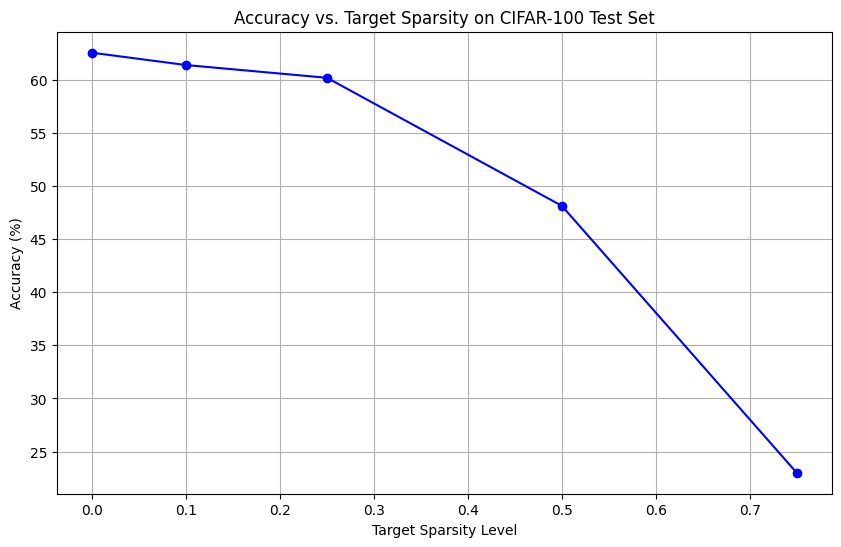

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import transforms, datasets
from tqdm import tqdm
import torch.nn.utils.prune as prune
import numpy as np

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for the CIFAR-100 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to load and configure a VGG-11 model for CIFAR-100 (100 classes)
def load_model_for_cifar100(model_path):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=False)  # Load VGG-11 model
    model.classifier[6] = nn.Linear(4096, 100)  # Modify the final layer for CIFAR-100 (100 classes)
    model.load_state_dict(torch.load(model_path))
    return model

# Load the baseline model
baseline_model_path = '/content/drive/MyDrive/vgg11_baseline.pth'
baseline_model = load_model_for_cifar100(baseline_model_path)
baseline_model = baseline_model.to(device)

# Function to freeze all layers except the final layer and prepare for fine-tuning
def prepare_model_for_finetuning(model):
    for param in model.features.parameters():
        param.requires_grad = False
    for param in model.classifier[:-1]:  # Freeze all but last layer in classifier
        param.requires_grad = False
    return model

# Function to fine-tune the model for a few epochs
def finetune_model(model, train_loader, epochs=3):
    model = prepare_model_for_finetuning(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001, weight_decay=1e-4)
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Fine-tuning Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Function to calculate accuracy
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Perform pruning and evaluate accuracy
sparsity_levels = [0, 0.1, 0.25, 0.5, 0.75]  # Target sparsity levels
accuracies = []

for sparsity in sparsity_levels:
    # Reload the baseline model for each sparsity level
    model = load_model_for_cifar100(baseline_model_path).to(device)

    # Apply unstructured pruning based on the target sparsity
    if sparsity > 0:
        for name, layer in model.named_modules():
            if isinstance(layer, (nn.Conv2d, nn.Linear)):
                prune.l1_unstructured(layer, name='weight', amount=sparsity)
                prune.remove(layer, 'weight')  # Make pruning permanent

    # Fine-tune the model
    finetune_model(model, train_loader, epochs=3)

    # Calculate accuracy on the test set
    accuracy = calculate_accuracy(model, test_loader)
    accuracies.append(accuracy * 100)  # Store accuracy in percentage

# Plot Accuracy vs. Sparsity
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels, accuracies, marker='o', color='b')
plt.xlabel("Target Sparsity Level")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Target Sparsity on CIFAR-100 Test Set")
plt.grid(True)
plt.show()
